In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed May 29 17:53:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   52C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 16


In [4]:
!pip3 install torch --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.7 MB/s eta 0:00:00


In [5]:
!pip install numpy scikit-learn matplotlib visualkeras braindecode==0.8.1 skorch torchviz -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 60.5 MB/s eta 0:00:00


In [6]:
# !python /content/drive/MyDrive/bme442/bme442project/preprocess.py

In [7]:
import numpy as np
import pickle
import mne

import torch
import torch.optim as optim
from torch import nn
from torch.nn.functional import elu
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchviz import make_dot

from braindecode.models.base import EEGModuleMixin, deprecated_args
from braindecode.models.functions import squeeze_final_output
from braindecode.models.modules import Ensure4d, Expression

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, TrainEndCheckpoint

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from einops.layers.torch import Rearrange

import matplotlib.pyplot as plt

import os
import concurrent.futures
import logging
import time
from tqdm import tqdm

In [8]:
cuda = torch.cuda.is_available()

In [9]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
base_dir = '/content/drive/MyDrive/bme442/bme442project'
preprocessed_data_dir = os.path.join(base_dir, 'preprocessed_data')

In [10]:
# someList = []
# with open('/content/drive/MyDrive/bme442/bme442project/preprocessed_data/S001/task_2/run_4.pkl', 'rb') as f:
#     data = pickle.load(f)
#     print('X: ', data['X'])
#     # someList.append(data['X'][28])
#     print('y: ', data['y'])

# # print(someList)

In [11]:
def process_run(run_path, test_flag):
    logging.info(f"Processing file: {run_path}")
    with open(run_path, 'rb') as f:
        data = pickle.load(f)

        # Get indices of all `1`s in `data['y']`
        one_indices = [i for i, y in enumerate(data['y']) if y == 1]

        # Create a set of indices to filter out: 4 out of every 5 `1`s
        filter_indices = set(one_indices[1::5] + one_indices[2::5] + one_indices[3::5] + one_indices[4::5])

        # Filter data
        filtered_X = [x for i, x in enumerate(data['X']) if i not in filter_indices]
        filtered_y = [y for i, y in enumerate(data['y']) if i not in filter_indices]

        if test_flag:
            return filtered_X, filtered_y, 'test'
        else:
            return filtered_X, filtered_y, 'train'

In [12]:
def process_subject(subject):
    global test_flag
    subject_dir = os.path.join(preprocessed_data_dir, subject)
    tasks = ['task_1', 'task_2', 'task_3', 'task_4']
    results = []

    if subject == 'S095':
        test_flag = True

    if os.path.isdir(subject_dir):
        for task in tasks:
            task_dir = os.path.join(subject_dir, task)
            if os.path.isdir(task_dir):
                for run_file in os.listdir(task_dir):
                    if run_file.endswith('.pkl'):
                        run_path = os.path.join(task_dir, run_file)
                        results.append((run_path, test_flag))

    return results

In [13]:
test_flag = False
X_combined = []
y_combined = []
X_combined_test = []
y_combined_test = []
all_runs = []
counter = 0

In [14]:
# Process all subjects concurrently
with concurrent.futures.ThreadPoolExecutor() as subject_executor:
    subject_futures = {subject_executor.submit(process_subject, subject): subject for subject in os.listdir(preprocessed_data_dir)}

    for future in tqdm(concurrent.futures.as_completed(subject_futures), total=len(subject_futures), desc="Processing subjects"):
        try:
            subject_runs = future.result()
            all_runs.extend(subject_runs)
        except Exception as e:
            subject = subject_futures[future]
            print(f"Error processing subject {subject}: {e}")

Processing subjects: 100%|██████████| 110/110 [00:11<00:00,  9.28it/s]


In [15]:
# Process all runs concurrently
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for run_path, flag in all_runs:
        futures.append(executor.submit(process_run, run_path, flag))

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing runs"):
        filtered_X, filtered_y, dataset_type = future.result()
        if dataset_type == 'test':
            X_combined_test.extend(filtered_X)
            y_combined_test.extend(filtered_y)
        else:
            X_combined.extend(filtered_X)
            y_combined.extend(filtered_y)

Processing runs: 100%|██████████| 1308/1308 [01:53<00:00, 11.48it/s]


In [16]:
# Subtract one from every y value
y_combined = [y - 1 for y in y_combined]
y_combined_test = [y - 1 for y in y_combined_test]

In [17]:
y_combined = np.array(y_combined)
X_combined = np.array(X_combined)
y_combined_test = np.array(y_combined_test)
X_combined_test = np.array(X_combined_test)

y_combined.shape, X_combined.shape, y_combined_test.shape, X_combined_test.shape

((16529,), (16529, 64, 656), (6128,), (6128, 64, 656))

In [18]:
print("X_combined shape:", X_combined.shape)
print("y_combined shape:", y_combined.shape)

X_combined shape: (16529, 64, 656)
y_combined shape: (16529,)


In [19]:
unique, counts = np.unique(y_combined, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2880, 1: 3597, 2: 3234, 3: 3572, 4: 3246}


In [20]:
if X_combined.shape[0] != y_combined.shape[0]:
    raise ValueError("Mismatch between number of samples in X_combined and y_combined.")

if X_combined_test.shape[0] != y_combined_test.shape[0]:
    raise ValueError("Mismatch between number of samples in X_combined_test and y_combined_test.")

In [21]:
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        self.weight.data = torch.renorm(
            self.weight.data, p=2, dim=0, maxnorm=self.max_norm
        )
        return super(Conv2dWithConstraint, self).forward(x)

In [22]:
def _glorot_weight_zero_bias(model):
    """Initialize parameters of all modules by initializing weights with
    glorot
     uniform/xavier initialization, and setting biases to zero. Weights from
     batch norm layers are set to 1.

    Parameters
    ----------
    model: Module
    """
    for module in model.modules():
        if hasattr(module, "weight"):
            if "BatchNorm" not in module.__class__.__name__:
                nn.init.xavier_uniform_(module.weight, gain=1)
            else:
                nn.init.constant_(module.weight, 1)
        if hasattr(module, "bias"):
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

In [23]:
# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [24]:
class EEGNetv4(EEGModuleMixin, nn.Sequential):
    """EEGNet v4 model from Lawhern et al 2018.

    See details in [EEGNet4]_.

    Parameters
    ----------
    final_conv_length : int | "auto"
        If int, final length of convolutional filters.
    in_chans :
        Alias for n_chans.
    n_classes:
        Alias for n_outputs.
    input_window_samples :
        Alias for n_times.

    Notes
    -----
    This implementation is not guaranteed to be correct, has not been checked
    by original authors, only reimplemented from the paper description.

    References
    ----------
    .. [EEGNet4] Lawhern, V. J., Solon, A. J., Waytowich, N. R., Gordon,
       S. M., Hung, C. P., & Lance, B. J. (2018).
       EEGNet: A Compact Convolutional Network for EEG-based
       Brain-Computer Interfaces.
       arXiv preprint arXiv:1611.08024.
    """

    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        final_conv_length="auto",
        pool_mode="mean",
        F1=8,
        D=2,
        F2=16,  # usually set to F1*D (?)
        kernel_length=64,
        third_kernel_size=(8, 4),
        drop_prob=0.25,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
        in_chans=None,
        n_classes=None,
        input_window_samples=None,
    ):
        n_chans, n_outputs, n_times = deprecated_args(
            self,
            ("in_chans", "n_chans", in_chans, n_chans),
            ("n_classes", "n_outputs", n_classes, n_outputs),
            ("input_window_samples", "n_times", input_window_samples, n_times),
        )
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq
        del in_chans, n_classes, input_window_samples
        if final_conv_length == "auto":
            assert self.n_times is not None
        self.final_conv_length = final_conv_length
        self.pool_mode = pool_mode
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.kernel_length = kernel_length
        self.third_kernel_size = third_kernel_size
        self.drop_prob = drop_prob
        # For the load_state_dict
        # When padronize all layers,
        # add the old's parameters here
        self.mapping = {
            "conv_classifier.weight": "final_layer.conv_classifier.weight",
            "conv_classifier.bias": "final_layer.conv_classifier.bias",
        }

        pool_class = dict(max=nn.MaxPool2d, mean=nn.AvgPool2d)[self.pool_mode]
        self.add_module("ensuredims", Ensure4d())

        self.add_module("dimshuffle", Rearrange("batch ch t 1 -> batch 1 ch t"))
        self.add_module(
            "conv_temporal",
            nn.Conv2d(
                1,
                self.F1,
                (1, self.kernel_length),
                stride=1,
                bias=False,
                padding=(0, self.kernel_length // 2),
            ),
        )
        self.add_module(
            "bnorm_temporal",
            nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
        )
        self.add_module(
            "conv_spatial",
            Conv2dWithConstraint(
                self.F1,
                self.F1 * self.D,
                (self.n_chans, 1),
                max_norm=1,
                stride=1,
                bias=False,
                groups=self.F1,
                padding=(0, 0),
            ),
        )

        self.add_module(
            "bnorm_1",
            nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
        )
        self.add_module("elu_1", Expression(elu))

        self.add_module("pool_1", pool_class(kernel_size=(1, 4), stride=(1, 4)))
        self.add_module("drop_1", nn.Dropout(p=self.drop_prob))

        # https://discuss.pytorch.org/t/how-to-modify-a-conv2d-to-depthwise-separable-convolution/15843/7
        self.add_module(
            "conv_separable_depth",
            nn.Conv2d(
                self.F1 * self.D,
                self.F1 * self.D,
                (1, 16),
                stride=1,
                bias=False,
                groups=self.F1 * self.D,
                padding=(0, 16 // 2),
            ),
        )
        self.add_module(
            "conv_separable_point",
            nn.Conv2d(
                self.F1 * self.D,
                self.F2,
                (1, 1),
                stride=1,
                bias=False,
                padding=(0, 0),
            ),
        )

        self.add_module(
            "bnorm_2",
            nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3),
        )
        self.add_module("elu_2", Expression(elu))
        self.add_module("pool_2", pool_class(kernel_size=(1, 8), stride=(1, 8)))
        self.add_module("drop_2", nn.Dropout(p=self.drop_prob))

        output_shape = self.get_output_shape()
        n_out_virtual_chans = output_shape[2]

        if self.final_conv_length == "auto":
            n_out_time = output_shape[3]
            self.final_conv_length = n_out_time

        # Incorporating classification module and subsequent ones in one final layer
        module = nn.Sequential()

        module.add_module(
            "conv_classifier",
            nn.Conv2d(
                self.F2,
                self.n_outputs,
                (n_out_virtual_chans, self.final_conv_length),
                bias=True,
            ),
        )

        if self.add_log_softmax:
            module.add_module("logsoftmax", nn.LogSoftmax(dim=1))

        # Transpose back to the logic of braindecode,
        # so time in third dimension (axis=2)
        module.add_module(
            "permute_back",
            Rearrange("batch x y z -> batch x z y"),
        )

        module.add_module("squeeze", Expression(squeeze_final_output))

        self.add_module("final_layer", module)

        _glorot_weight_zero_bias(self)

    def forward(self, x):
        logger.info(f'Input shape: {x.shape}')
        x = super().forward(x)
        logger.info(f'Output shape: {x.shape}')
        return x


In [25]:
# Ensure device is correctly set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Check for NaN or infinite values in the data
assert not np.isnan(X_combined).any(), "X_combined contains NaN values"
assert not np.isinf(X_combined).any(), "X_combined contains infinite values"
assert not np.isnan(y_combined).any(), "y_combined contains NaN values"
assert not np.isinf(y_combined).any(), "y_combined contains infinite values"

# Step 2: Convert to PyTorch tensors on CPU first
X_combined_tensor_cpu = torch.from_numpy(X_combined).float()
y_combined_tensor_cpu = torch.from_numpy(y_combined).long()

# Check the tensors on CPU
print(f"Shape of X_combined_tensor_cpu: {X_combined_tensor_cpu.shape}")
print(f"Shape of y_combined_tensor_cpu: {y_combined_tensor_cpu.shape}")

# Test with a small batch
small_batch_X = X_combined_tensor_cpu[:10]
small_batch_y = y_combined_tensor_cpu[:10]

try:
    small_batch_X_cuda = small_batch_X.to(device)
    small_batch_y_cuda = small_batch_y.to(device)
    print("Small batch transfer successful")
except RuntimeError as e:
    print(f"Error during small batch transfer: {e}")

# Inspect the data for unusual values
print("X_combined max:", X_combined.max())
print("X_combined min:", X_combined.min())
print("X_combined mean:", X_combined.mean())

print("y_combined unique values:", np.unique(y_combined))

# Enable CUDA debugging mode
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Move the tensors to the CUDA device again
try:
    X_combined_tensor = X_combined_tensor_cpu.to(device)
    y_combined_tensor = y_combined_tensor_cpu.to(device)
    print("Data transfer to CUDA successful")
except RuntimeError as e:
    print(f"Error during data transfer to CUDA: {e}")

Shape of X_combined_tensor_cpu: torch.Size([16529, 64, 656])
Shape of y_combined_tensor_cpu: torch.Size([16529])
Small batch transfer successful
X_combined max: 1.2325758883830138
X_combined min: -1.0911326279824438
X_combined mean: -1.6499859182095257e-06
y_combined unique values: [0 1 2 3 4]
Data transfer to CUDA successful


In [26]:
# Define the EEGNetv4 model as above and instantiate it
model = EEGNetv4(n_chans=64, n_outputs=5, n_times=656, kernel_length=32)

# Generate a sample input tensor with the same shape as expected by the model
x = torch.randn(170, 64, 656)

# Perform a forward pass to generate the computation graph
y = model(x)

# Use torchviz to visualize the computation graph
dot = make_dot(y, params=dict(model.named_parameters()))

# Render and save the graph to a file
dot.render("eegnetv4_graph", format="png")

# Display the graph
dot.view()

'eegnetv4_graph.pdf'

In [27]:
def process_fold(train_index, test_index, X_combined, y_combined, batch_size=128):
    print("process_fold called")
    assert torch.cuda.is_available(), "CUDA is not available. Check your GPU setup."
    torch.backends.cudnn.enabled = False  # Disable cuDNN for debugging purposes

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y_combined[train_index], y_combined[test_index]

    # Check for NaN or infinite values in the data
    assert not np.isnan(X_train).any(), "X_train contains NaN values"
    assert not np.isinf(X_train).any(), "X_train contains infinite values"
    assert not np.isnan(X_test).any(), "X_test contains NaN values"
    assert not np.isinf(X_test).any(), "X_test contains infinite values"
    assert not np.isnan(y_train).any(), "y_train contains NaN values"
    assert not np.isinf(y_train).any(), "y_train contains infinite values"
    assert not np.isnan(y_test).any(), "y_test contains NaN values"
    assert not np.isinf(y_test).any(), "y_test contains infinite values"

    # Convert data to PyTorch tensors
    X_train_tensor_cpu = torch.from_numpy(X_train).float()
    X_test_tensor_cpu = torch.from_numpy(X_test).float()
    y_train_tensor_cpu = torch.from_numpy(y_train).long()
    y_test_tensor_cpu = torch.from_numpy(y_test).long()

    # Transfer full tensors to the CUDA device
    X_train = X_train_tensor_cpu.to(device)
    X_test = X_test_tensor_cpu.to(device)
    y_train = y_train_tensor_cpu.to(device)
    y_test = y_test_tensor_cpu.to(device)

    # Define the model
    model = EEGNetv4(n_chans=64, n_outputs=5, n_times=656, kernel_length=32)
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.05, capturable=False)  # capturable=False to avoid CUDA assertion

    # Training loop
    def train_model(model, criterion, optimizer, X_train, y_train, n_epochs=200, batch_size=128):
        model.train()
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(n_epochs):
            epoch_start_time = time.time()
            running_loss = 0.0
            for batch_idx, (inputs, labels) in enumerate(dataloader):
                batch_start_time = time.time()
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                batch_end_time = time.time()
                print(f'Batch {batch_idx + 1}/{len(dataloader)} processed in {batch_end_time - batch_start_time:.4f} seconds')

            avg_loss = running_loss / len(dataloader)
            epoch_end_time = time.time()
            logger.info(f'Epoch [{epoch + 1}/{n_epochs}] completed in {epoch_end_time - epoch_start_time:.4f} seconds, Average Loss: {avg_loss:.4f}')

    logger.info('Starting model training...')
    print('Starting model training...')
    train_model(model, criterion, optimizer, X_train, y_train, batch_size=batch_size)
    logger.info('Model training completed.')
    print('Model training completed.')

    # Predict and evaluate
    logger.info('Starting prediction...')
    print('Starting prediction...')
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, y_pred = torch.max(outputs, 1)

    y_pred = y_pred.cpu().numpy()
    accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
    logger.info(f'Fold accuracy: {accuracy:.4f}')
    print(f'Fold accuracy: {accuracy:.4f}')

    # Generate confusion matrix
    cm = confusion_matrix(y_test.cpu().numpy(), y_pred)
    logger.info(f'Confusion Matrix:\n{cm}')
    print(f'Confusion Matrix:\n{cm}')

    # Calculate sensitivities, specificities, PPVs, and NPVs
    fold_sensitivities = []
    fold_specificities = []
    fold_ppvs = []
    fold_npvs = []

    for i in range(5):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
        fold_ppvs.append(ppv)
        fold_npvs.append(npv)

    logger.info(f'Fold sensitivities: {fold_sensitivities}')
    print(f'Fold sensitivities: {fold_sensitivities}')
    logger.info(f'Fold specificities: {fold_specificities}')
    print(f'Fold specificities: {fold_specificities}')
    logger.info(f'Fold PPVs: {fold_ppvs}')
    print(f'Fold PPVs: {fold_ppvs}')
    logger.info(f'Fold NPVs: {fold_npvs}')
    print(f'Fold NPVs: {fold_npvs}')

    return model, fold_sensitivities, fold_specificities, fold_ppvs, fold_npvs, cm

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_sensitivities = []
all_specificities = []
all_ppvs = []
all_npvs = []
models = []
cms = []

In [29]:
# Check if the trained_models directory exists and create if it doesn't
os.makedirs(os.path.join(base_dir, 'trained_models'), exist_ok=True)

# Check for existing models
existing_models = os.listdir(os.path.join(base_dir, "trained_models"))

if existing_models:
    print("Loading existing models...")
    for fold_index, model_file in enumerate(existing_models, start=1):
        model_path = os.path.join(base_dir, 'trained_models', model_file)
        model = EEGNetv4(n_chans=64, n_outputs=5, n_times=656, kernel_length=32)
        model.load_state_dict(torch.load(model_path))
        models.append(model)
        print(f"Loaded model for fold {fold_index}")
else:
    print("Starting StratifiedKFold cross-validation")

    fold_index = 1

    for train_index, test_index in skf.split(X_combined, y_combined):
        print(f"Processing fold {fold_index}")
        model, sensitivities, specificities, ppvs, npvs, cm = process_fold(train_index, test_index, X_combined, y_combined, batch_size=2048)
        if sensitivities and specificities and ppvs and npvs:
            all_sensitivities.append(sensitivities)
            all_specificities.append(specificities)
            all_ppvs.append(ppvs)
            all_npvs.append(npvs)
        models.append(model)
        cms.append(cm)
        model_save_path = os.path.join(base_dir, 'trained_models', f'model_fold_{fold_index}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Completed fold {fold_index}")
        fold_index += 1

    print("Completed StratifiedKFold cross-validation")

Loading existing models...
Loaded model for fold 1
Loaded model for fold 2
Loaded model for fold 3
Loaded model for fold 4
Loaded model for fold 5


In [30]:
# Convert lists to numpy arrays for further analysis
all_sensitivities = np.array(all_sensitivities)
all_specificities = np.array(all_specificities)
all_ppvs = np.array(all_ppvs)
all_npvs = np.array(all_npvs)

print(f'Mean Sensitivities per fold: {all_sensitivities.mean(axis=0)}')
print(f'Mean Specificities per fold: {all_specificities.mean(axis=0)}')
print(f'Mean PPVs per fold: {all_ppvs.mean(axis=0)}')
print(f'Mean NPVs per fold: {all_npvs.mean(axis=0)}')

Mean Sensitivities per fold: nan
Mean Specificities per fold: nan
Mean PPVs per fold: nan
Mean NPVs per fold: nan


<ipython-input-30-ebe64ec35700>:7: RuntimeWarning: Mean of empty slice.
  print(f'Mean Sensitivities per fold: {all_sensitivities.mean(axis=0)}')
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-30-ebe64ec35700>:8: RuntimeWarning: Mean of empty slice.
  print(f'Mean Specificities per fold: {all_specificities.mean(axis=0)}')
<ipython-input-30-ebe64ec35700>:9: RuntimeWarning: Mean of empty slice.
  print(f'Mean PPVs per fold: {all_ppvs.mean(axis=0)}')
<ipython-input-30-ebe64ec35700>:10: RuntimeWarning: Mean of empty slice.
  print(f'Mean NPVs per fold: {all_npvs.mean(axis=0)}')


In [31]:
# Assuming you have these variables defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# Test the resulting models with y_combined_test and X_combined_test
X_combined_test_tensor = torch.from_numpy(X_combined_test).float().to(device)
y_combined_test_tensor = torch.from_numpy(y_combined_test).long().to(device)

In [33]:
all_test_sensitivities = []
all_test_specificities = []
all_test_ppvs = []
all_test_npvs = []
test_cms = []

In [34]:
cms = []

for i, model in enumerate(models, 1):
    model.to(device)  # Ensure the model is on the same device as the input
    model.eval()
    with torch.no_grad():
        outputs = model(X_combined_test_tensor)
        _, y_pred = torch.max(outputs, 1)

    y_pred = y_pred.cpu().numpy()
    cm = confusion_matrix(y_combined_test, y_pred)
    cms.append(cm)
    test_cms.append(cm)
    print(f'Confusion Matrix for model {i}:\n{cm}')
    # torch.save(model.state_dict(), os.path.join(base_dir, 'trained_models', f'model_test_{i}.pth'))

    # Calculate sensitivities, specificities, PPVs, and NPVs
    test_sensitivities = []
    test_specificities = []
    test_ppvs = []
    test_npvs = []

    for j in range(len(cm)):  # Adjusted to use len(cm) for the range
        tp = cm[j, j]
        fn = cm[j, :].sum() - tp
        fp = cm[:, j].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        test_sensitivities.append(sensitivity)
        test_specificities.append(specificity)
        test_ppvs.append(ppv)
        test_npvs.append(npv)

    all_test_sensitivities.append(test_sensitivities)
    all_test_specificities.append(test_specificities)
    all_test_ppvs.append(test_ppvs)
    all_test_npvs.append(test_npvs)

print("Completed testing models on the test set")

Confusion Matrix for model 1:
[[699  96   5 231  37]
 [245 502  24 311  18]
 [269 270  88 781  20]
 [157 101   8 822   8]
 [389 226  20 661 140]]
Confusion Matrix for model 2:
[[197 209 276 257 129]
 [ 17 634 213 195  41]
 [ 26 245 713 380  64]
 [ 13 139 165 726  53]
 [ 31 266 329 401 409]]
Confusion Matrix for model 3:
[[847  92   1  40  88]
 [341 627   4  65  63]
 [662 419  28 124 195]
 [445 251   1 312  87]
 [621 275   7  91 442]]
Confusion Matrix for model 4:
[[598 384  19  16  51]
 [173 875  18   5  29]
 [267 848 166  37 110]
 [219 513  37 266  61]
 [277 764  47  32 316]]
Confusion Matrix for model 5:
[[538 119  23 217 171]
 [144 542  31 216 167]
 [201 267 189 502 269]
 [158 103  36 671 128]
 [174 190  38 359 675]]
Completed testing models on the test set


In [35]:
# prompt: A better visual representation for confusion matrices

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the confusion matrices to pandas DataFrames
df_cms = []
for i, cm in enumerate(cms, 1):
    df_cm = pd.DataFrame(cm, columns=[f'Predicted Class {i}' for i in range(5)], index=[f'Actual Class {i}' for i in range(5)])
    df_cms.append(df_cm)


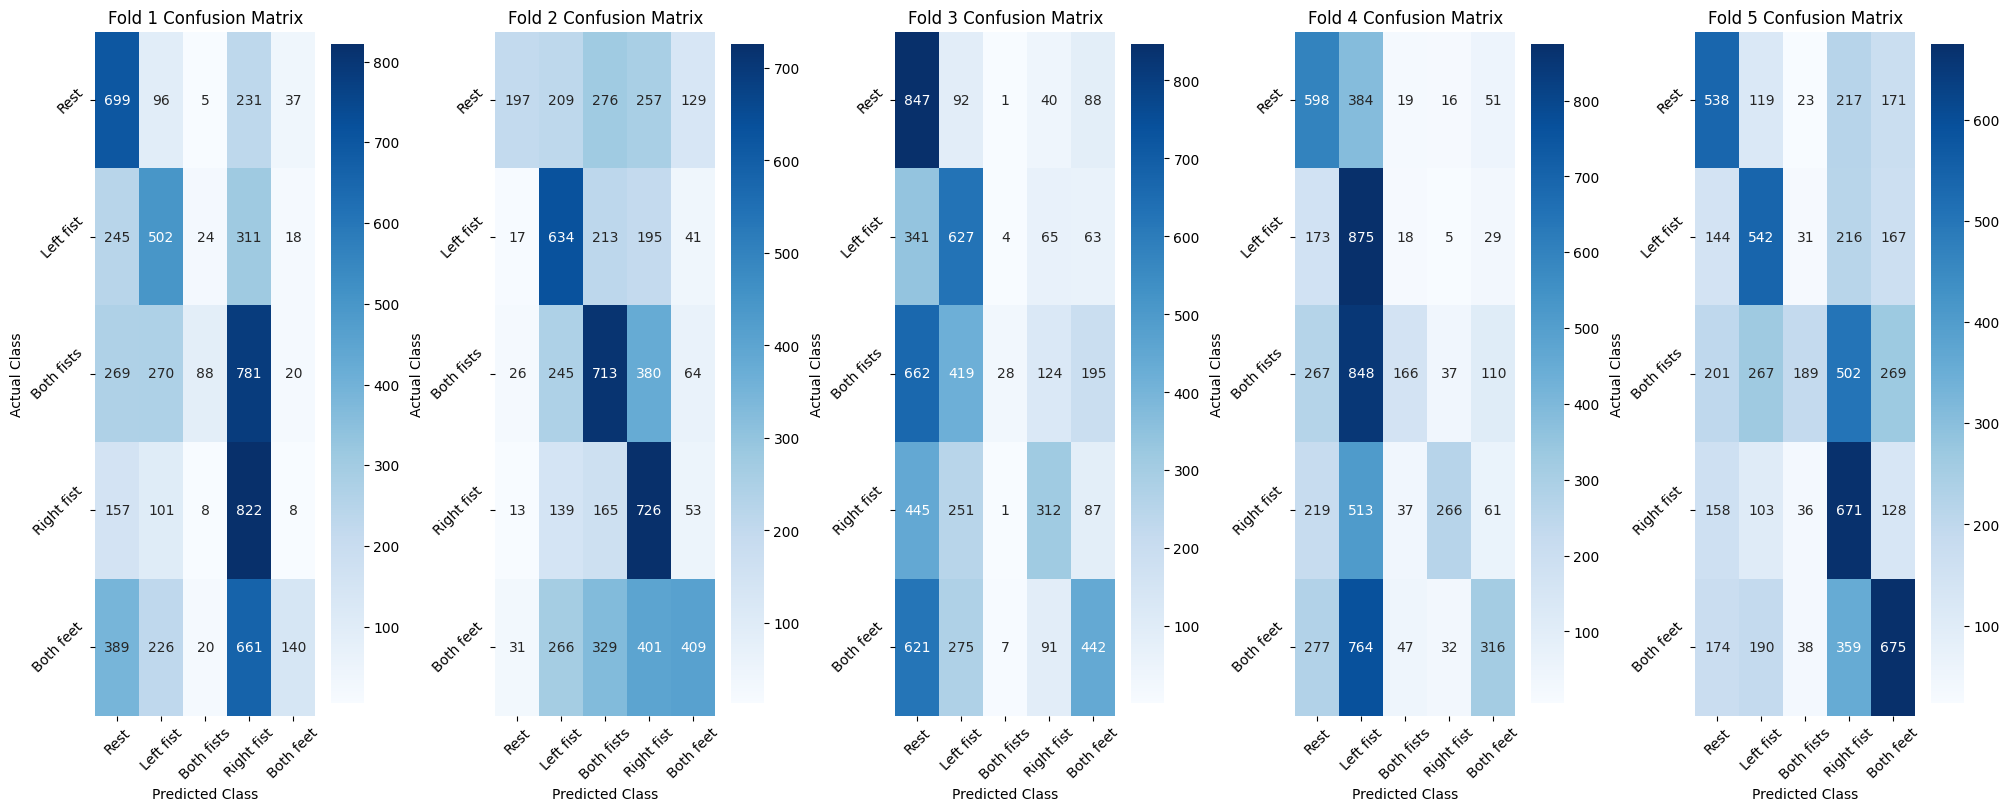

In [36]:
# Define the class names
class_names = ['Rest', 'Left fist', 'Both fists', 'Right fist', 'Both feet']

# Create a figure with subplots for each fold, adjusting layout and size
fig, axes = plt.subplots(1, len(df_cms), figsize=(20, 8), constrained_layout=True)

# Plot each confusion matrix
for i, df_cm in enumerate(df_cms, 1):
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', ax=axes[i-1], xticklabels=class_names, yticklabels=class_names)
    axes[i-1].set_xlabel('Predicted Class')
    axes[i-1].set_ylabel('Actual Class')
    axes[i-1].set_title(f'Fold {i} Confusion Matrix')
    axes[i-1].tick_params(axis='x', rotation=45)
    axes[i-1].tick_params(axis='y', rotation=45)

plt.show()

In [37]:
all_test_sensitivities = np.array(all_test_sensitivities)
all_test_specificities = np.array(all_test_specificities)
all_test_ppvs = np.array(all_test_ppvs)
all_test_npvs = np.array(all_test_npvs)

all_test_accuracies = (all_test_sensitivities + all_test_specificities) / 2

print(f'Mean Test Sensitivities: {all_test_sensitivities}')
print(f'Mean Test Specificities: {all_test_specificities}')
print(f'Mean Test PPVs: {all_test_ppvs}')
print(f'Mean Test NPVs: {all_test_npvs}')

Mean Test Sensitivities: [[0.65449438 0.45636364 0.06162465 0.75       0.09749304]
 [0.18445693 0.57636364 0.49929972 0.66240876 0.28481894]
 [0.79307116 0.57       0.01960784 0.28467153 0.30779944]
 [0.55992509 0.79545455 0.1162465  0.24270073 0.22005571]
 [0.50374532 0.49272727 0.13235294 0.61222628 0.47005571]]
Mean Test Specificities: [[0.79051383 0.86217184 0.98787234 0.60572337 0.98231032]
 [0.98280632 0.82915672 0.79085106 0.7549682  0.93883205]
 [0.59110672 0.79375497 0.99723404 0.936407   0.90771526]
 [0.81501976 0.50099443 0.97425532 0.98211447 0.94650469]
 [0.86620553 0.86495625 0.97276596 0.74284579 0.84335038]]
Mean Test PPVs: [[0.39738488 0.42008368 0.60689655 0.29294369 0.62780269]
 [0.69366197 0.42464836 0.42040094 0.37059724 0.58764368]
 [0.29046639 0.37680288 0.68292683 0.49367089 0.50514286]
 [0.38983051 0.25856974 0.57839721 0.74719101 0.55731922]
 [0.44279835 0.44389844 0.59621451 0.34147583 0.4787234 ]]
Mean Test NPVs: [[0.91554131 0.87877559 0.77603209 0.91751957

In [38]:
# Convert to DataFrames with class names as indices
df_sensitivities = pd.DataFrame(all_test_sensitivities * 100, index=class_names, columns=[f'Fold {i+1}' for i in range(all_test_sensitivities.shape[1])])
df_specificities = pd.DataFrame(all_test_specificities * 100, index=class_names, columns=[f'Fold {i+1}' for i in range(all_test_specificities.shape[1])])
df_ppvs = pd.DataFrame(all_test_ppvs * 100, index=class_names, columns=[f'Fold {i+1}' for i in range(all_test_ppvs.shape[1])])
df_npvs = pd.DataFrame(all_test_npvs * 100, index=class_names, columns=[f'Fold {i+1}' for i in range(all_test_npvs.shape[1])])
df_accuracies = pd.DataFrame(all_test_accuracies * 100, index=class_names, columns=[f'Fold {i+1}' for i in range(all_test_accuracies.shape[1])])



# Print the tables
print("Test Sensitivities by Fold")
print(df_sensitivities)
print("\nTest Specificities by Fold")
print(df_specificities)
print("\nTest PPVs by Fold")
print(df_ppvs)
print("\nTest NPVs by Fold")
print(df_npvs)
print("\nTest Accuracies by Fold")
print(df_accuracies)

Test Sensitivities by Fold
               Fold 1     Fold 2     Fold 3     Fold 4     Fold 5
Rest        65.449438  45.636364   6.162465  75.000000   9.749304
Left fist   18.445693  57.636364  49.929972  66.240876  28.481894
Both fists  79.307116  57.000000   1.960784  28.467153  30.779944
Right fist  55.992509  79.545455  11.624650  24.270073  22.005571
Both feet   50.374532  49.272727  13.235294  61.222628  47.005571

Test Specificities by Fold
               Fold 1     Fold 2     Fold 3     Fold 4     Fold 5
Rest        79.051383  86.217184  98.787234  60.572337  98.231032
Left fist   98.280632  82.915672  79.085106  75.496820  93.883205
Both fists  59.110672  79.375497  99.723404  93.640700  90.771526
Right fist  81.501976  50.099443  97.425532  98.211447  94.650469
Both feet   86.620553  86.495625  97.276596  74.284579  84.335038

Test PPVs by Fold
               Fold 1     Fold 2     Fold 3     Fold 4     Fold 5
Rest        39.738488  42.008368  60.689655  29.294369  62.780269
Le

In [39]:
def display_table(df, title):
    df_formatted = df.round(2).astype(str) + '%'
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5 + 1))  # Adjust the size as needed
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, rowLabels=df_formatted.index, cellLoc='center', loc='center')
    ax.set_title(title)
    plt.show()

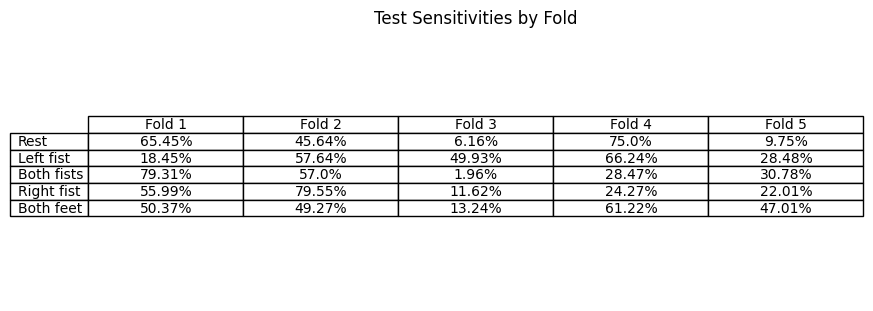

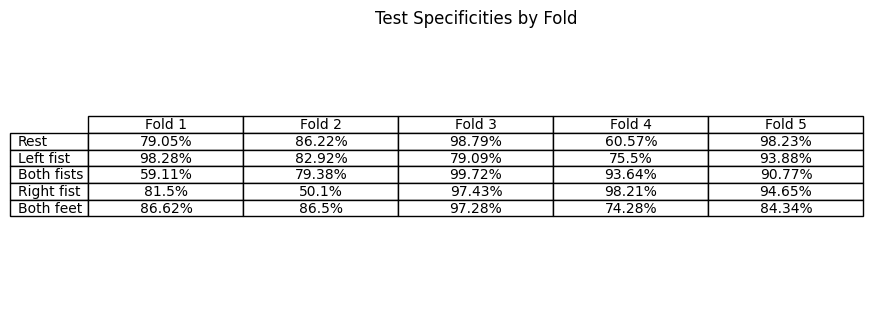

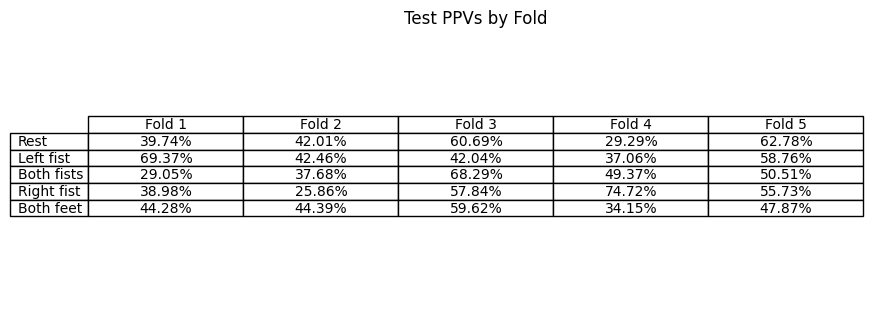

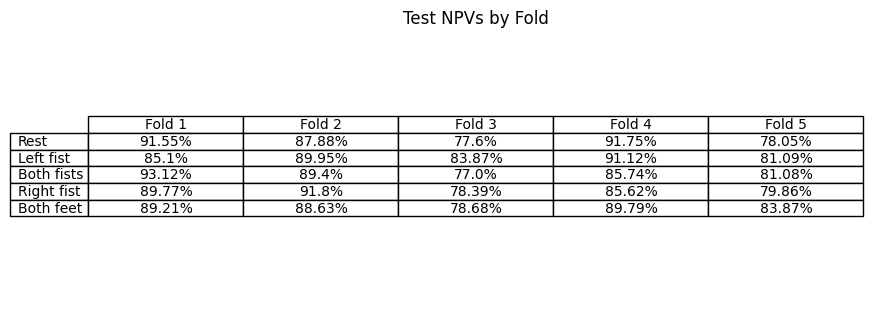

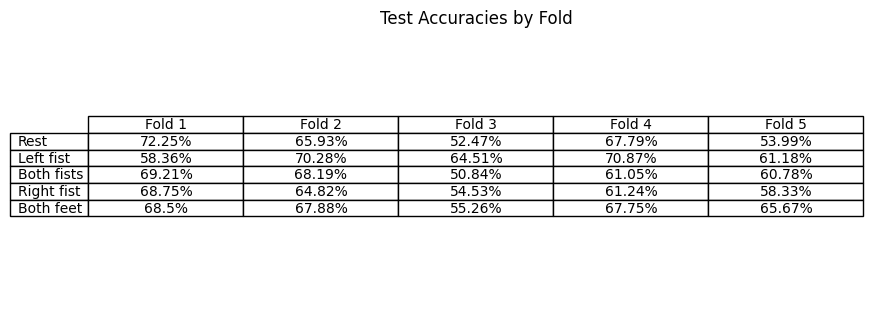

In [40]:
# Display each DataFrame as an image
display_table(df_sensitivities, 'Test Sensitivities by Fold')
display_table(df_specificities, 'Test Specificities by Fold')
display_table(df_ppvs, 'Test PPVs by Fold')
display_table(df_npvs, 'Test NPVs by Fold')
display_table(df_accuracies, 'Test Accuracies by Fold')

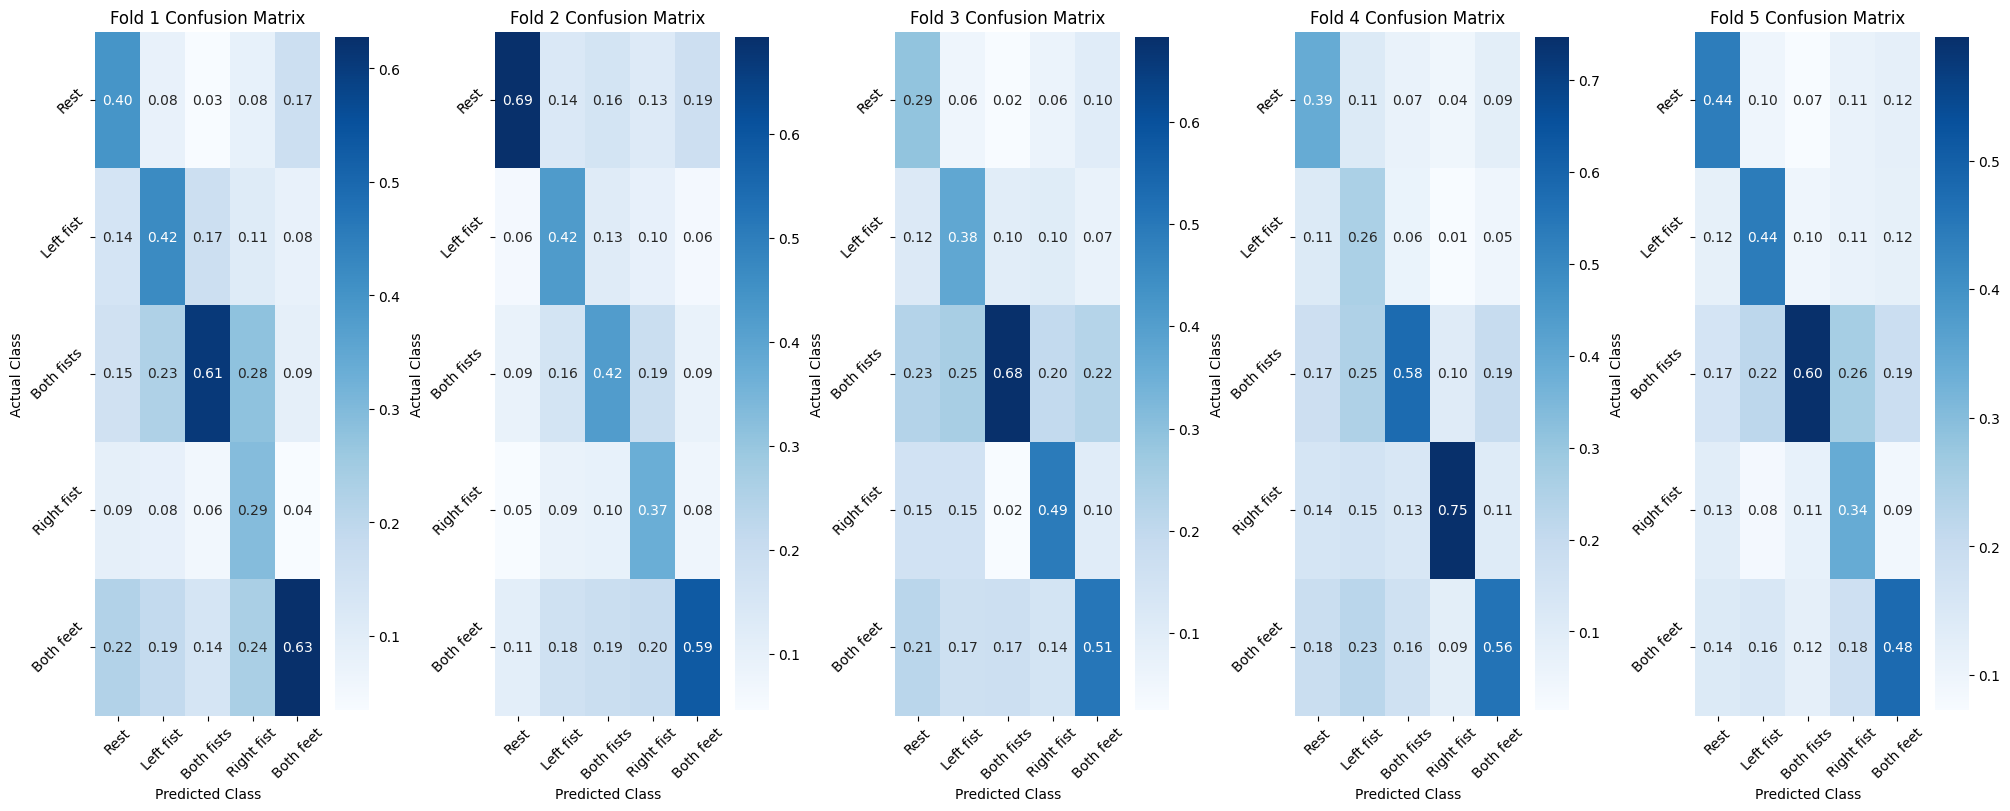

In [41]:
# Convert confusion matrices to numpy arrays if they are not already
df_cms = [np.array(cm) for cm in df_cms]

# Normalize the confusion matrices along the columns
df_cms_normalized = [cm.astype('float') / cm.sum(axis=0)[np.newaxis, :] for cm in df_cms]

# Define the class names
class_names = ['Rest', 'Left fist', 'Both fists', 'Right fist', 'Both feet']

# Create a figure with subplots for each fold, adjusting layout and size
fig, axes = plt.subplots(1, len(df_cms_normalized), figsize=(20, 8), constrained_layout=True)

# Plot each normalized confusion matrix
for i, df_cm in enumerate(df_cms_normalized, 1):
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i-1], xticklabels=class_names, yticklabels=class_names)
    axes[i-1].set_xlabel('Predicted Class')
    axes[i-1].set_ylabel('Actual Class')
    axes[i-1].set_title(f'Fold {i} Confusion Matrix')
    axes[i-1].tick_params(axis='x', rotation=45)
    axes[i-1].tick_params(axis='y', rotation=45)

plt.show()